In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import albumentations as A
import albumentations.pytorch
import random

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device: {}'.format(device))

device: cuda


In [5]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## EDA

In [6]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [7]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
Y_train = train_data['label']
X_train = train_data.drop(['label'], axis=1)
print(Y_train)
print(X_train)

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64
       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995       0       0       0       0       0       0       0       0       0   
41996       0       0       0       0       0       0       0       0       0   
41997       0       0       0       0       0       0       0       0       0   
41998       0       0       

In [10]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Data Preprocessing

In [11]:
X_train = X_train 
test_data = test_data 

print(X_train.max())

pixel0       0
pixel1       0
pixel2       0
pixel3       0
pixel4       0
            ..
pixel779    62
pixel780     0
pixel781     0
pixel782     0
pixel783     0
Length: 784, dtype: int64


In [12]:
print(test_data.max())
print(test_data.min())

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64
pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


convert dataframe into numpy array

In [13]:
X_train = X_train.values
Y_train = Y_train.values
test_data = test_data.values

In [14]:
X_train = X_train.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)

print(X_train.shape)
print(test_data.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


In [15]:
def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

(28, 28, 1)


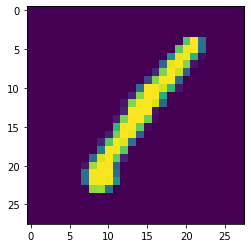

In [16]:
print(X_train[0].shape)
raw_image = X_train[0]
plt.imshow(raw_image)

(28, 28, 3)


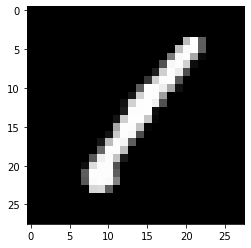

In [17]:
channel3_image = X_train[0]
channel3_image = np.repeat(channel3_image,3,axis=2)
print(channel3_image.shape)
plt.imshow(channel3_image)

<class 'numpy.ndarray'>
(2,)
[<AxesSubplot:> <AxesSubplot:>]


Text(0.5, 1.0, 'transformed')

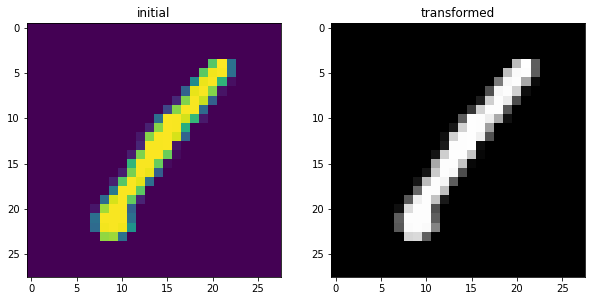

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,16))
print(type(ax))
print(ax.shape)
print(ax)
ax[0].imshow(raw_image)
ax[0].set_title('initial')
ax[1].imshow(channel3_image)
ax[1].set_title('transformed')

In [19]:
image = X_train[0]
image = image.astype(dtype=np.uint8)
transform = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.5,),std=(0.5,)),
    #A.pytorch.ToTensorV2()
                      ])
plt.imshow(transform(image=image)['image'])

In [20]:
print(image.shape)
print(image.min())
print(image.max())

(28, 28, 1)
0
255


In [21]:
transformed_image=transform(image=image)['image']
print(transformed_image.min())
print(transformed_image.max())
print(type(transformed_image))
print(transformed_image.shape)

tensor(-1.)
tensor(0.9922)
<class 'torch.Tensor'>
torch.Size([1, 28, 28])


In [22]:
class MNIST_dataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,idx):
        x = self.x[idx].astype(dtype=np.uint8)      
        y = torch.tensor(self.y[idx])
        if self.transform:
            x = self.transform(image = x)['image']
        return x, y
    
class MNIST_test_dataset(Dataset):
    def __init__(self, x, transform=None):
        self.x = x
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self,idx):
        x = self.x[idx].astype(dtype=np.uint8)
        if self.transform:
            x = self.transform(image = x)['image']
        return x
        

In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2, shuffle = True, stratify = Y_train, random_state=777)

train_dataset = MNIST_dataset(x_train, y_train, transform = albumentations.Compose([ 
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.5),std=(0.5)),
    A.pytorch.ToTensorV2()
]))
valid_dataset = MNIST_dataset(x_valid, y_valid,  transform = albumentations.Compose([ 
    A.Normalize(mean=(0.5),std=(0.5)),
    A.pytorch.ToTensorV2 ()
]))
test_dataset  = MNIST_test_dataset(test_data, transform = albumentations.Compose([ 
    A.Normalize(mean=(0.5),std=(0.5)),
    A.pytorch.ToTensorV2 ()
]))

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle=True)
valid_dataloader  = DataLoader(dataset = valid_dataset, batch_size = 64, shuffle=True)
test_dataloader  = DataLoader(dataset = test_dataset,  batch_size = 64)

## Model

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        
        self.fc1 = nn.Linear(128*8*8,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,10)
        
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.drop = nn.Dropout2d(p=0.5)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        #initilization
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')

        
    def forward(self,x):
        #x shape: 64*1*28*28
        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        #64*16*26*26
        
        out = self.conv2(out)
        out = self.batchnorm2(out) 
        out = self.relu(out)
        #64*32*24*24
        
        out = self.max_pool(out)
        #64*32*12*12
        
        out = self.conv3(out)
        out = self.batchnorm3(out) 
        out = self.relu(out)
        #64*64*10*10
        
        out = self.conv4(out)
        out = self.batchnorm4(out) 
        out = self.relu(out)
        #64*128*8*8
        #flatten
        out = out.view(out.size(0),-1)
        #64*128*8*8
        
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.drop(out)
        
        out = self.fc3(out)
        
        return out
        

In [25]:
model = CNN().to(device)

In [26]:
optimizer = optim.Adam(model.parameters(),lr=1e-3,betas=(0.9,0.999))
criterion = nn.CrossEntropyLoss()

In [27]:
total_epochs = 500
history = {'train_loss': [], 'valid_loss': [],'train_acc':[],'valid_acc':[]}
early_stopping = EarlyStopping(patience=100, verbose=True)
for epoch in range(total_epochs):
    train_acc, train_loss, valid_acc, valid_loss = 0, 0, 0, 0
    model.train()
    for (images, labels) in train_dataloader:
        images, labels = images.float().to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        prediction = torch.argmax(output, dim=1)
        train_acc += (prediction==labels).sum().item()
        
    model.eval()
    for images, labels in valid_dataloader:
        images, labels = images.float().to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        
        valid_loss += loss.item() * images.size(0)
        
        prediction = torch.argmax(output,dim=1)
        valid_acc += (prediction==labels).sum().item()
    
    
    train_loss = train_loss / len(train_dataset) 
    train_acc = train_acc / len(train_dataset) * 100
    valid_loss = valid_loss / len(valid_dataset)
    valid_acc = valid_acc / len(valid_dataset) * 100
    
    print("Epoch:{}/{} AVG Training Loss: {:.4f} AVG Test Loss: {:.3f} AVG Training ACC: {:.3f}% AVG Test ACC: {:.3f}%".format(
           epoch+1, total_epochs, train_loss, valid_loss, train_acc, valid_acc
        ))
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(valid_acc)
    
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop:
            print("Early stopping")
            break

Epoch:1/500 AVG Training Loss: 0.6192 AVG Test Loss: 0.076 AVG Training ACC: 82.827% AVG Test ACC: 97.774%
Validation loss decreased (inf --> 0.075748).  Saving model ...
Epoch:2/500 AVG Training Loss: 0.2216 AVG Test Loss: 0.049 AVG Training ACC: 93.551% AVG Test ACC: 98.452%
Validation loss decreased (0.075748 --> 0.049176).  Saving model ...
Epoch:3/500 AVG Training Loss: 0.1581 AVG Test Loss: 0.042 AVG Training ACC: 95.348% AVG Test ACC: 98.714%
Validation loss decreased (0.049176 --> 0.042040).  Saving model ...
Epoch:4/500 AVG Training Loss: 0.1381 AVG Test Loss: 0.038 AVG Training ACC: 96.107% AVG Test ACC: 98.964%
Validation loss decreased (0.042040 --> 0.037515).  Saving model ...
Epoch:5/500 AVG Training Loss: 0.1232 AVG Test Loss: 0.054 AVG Training ACC: 96.592% AVG Test ACC: 98.464%
EarlyStopping counter: 1 out of 100
Epoch:6/500 AVG Training Loss: 0.1076 AVG Test Loss: 0.033 AVG Training ACC: 96.997% AVG Test ACC: 99.107%
Validation loss decreased (0.037515 --> 0.033186). 

In [28]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [29]:
import numpy as np

model.eval()
test_pred = torch.LongTensor()
for data in test_dataloader:
    data = data.float().to(device)
    output=model(data)
    pred = torch.argmax(output,dim=1)
    #1-dimensional tensor->pred, test_pred
    test_pred = torch.cat((test_pred,pred.cpu()), dim=0)
    

first_column = np.arange(1,len(test_dataset)+1)
first_column = first_column.reshape(-1,1)
test_pred = test_pred.reshape(-1,1)
print(first_column)
print(test_pred)
test_df = pd.DataFrame(np.concatenate((first_column,test_pred.numpy()),axis=1), columns=['ImageId', 'Label'])
print(test_df)

[[    1]
 [    2]
 [    3]
 ...
 [27998]
 [27999]
 [28000]]
tensor([[2],
        [0],
        [9],
        ...,
        [3],
        [9],
        [2]])
       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]


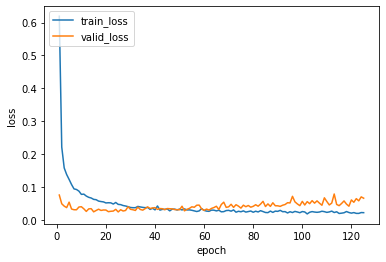

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
epochs = np.arange(1, len(history['train_loss'])+1)
plt.figure()
plt.plot(epochs, history['train_loss'], label = 'train_loss')
plt.plot(epochs, history['valid_loss'], label = 'valid_loss')
plt.legend(loc = "upper left")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

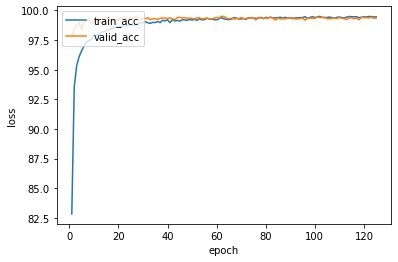

In [31]:
epochs = np.arange(1, len(history['train_loss'])+1)
plt.figure()
plt.plot(epochs, history['train_acc'], label = 'train_acc')
plt.plot(epochs, history['valid_acc'], label = 'valid_acc')
plt.legend(loc = "upper left")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [32]:
test_df.to_csv('submission.csv', index=False)

In [33]:
df = pd.read_csv('./submission.csv')
print(df)
print(df['Label'].max())

       ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      0
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]
9
